In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]
N_t = 1
N_r = 8
L_r = 4
L_t = 1

initial_position_cartesian = cylindrical_to_cartesian([3.5, math.radians(17.61267585), 0])
initial_position_cartesian 

array([3.33593312, 1.05903267, 0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

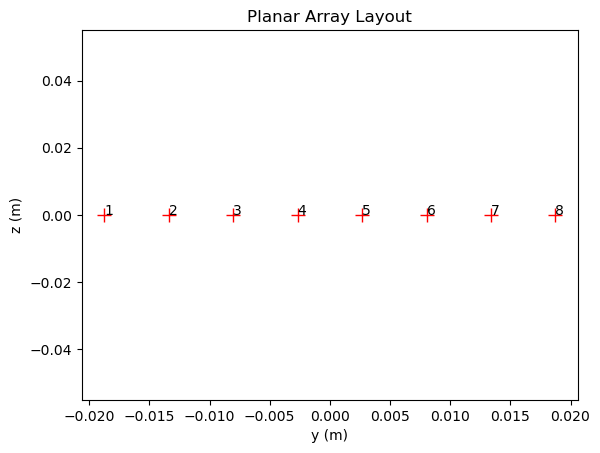

In [4]:
scene.frequency = 28e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")


scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")

scene.rx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)

In [5]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [6]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [2.78593, 0.809033, 0.84],
      max = [3.88593, 1.30903, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
       

In [7]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [8]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 8, 1, 1, 8, 1), dtype=complex64, numpy=
array([[[[[[[ 3.1864570e-06+2.1714809e-06j],
            [ 2.4275487e-06-2.8687834e-06j],
            [ 3.0766833e-07+1.6031779e-06j],
            [-3.8287180e-06-5.4430450e-07j],
            [-3.1936911e-06+1.8707481e-06j],
            [-3.0831222e-06-2.0775108e-06j],
            [ 2.5254017e-06-2.8962027e-06j],
            [ 1.0767129e-06+3.6877000e-06j]]]],



         [[[[-7.7864911e-07+3.7765781e-06j],
            [ 3.4257562e-06+1.5450272e-06j],
            [-1.0183528e-06+1.2758516e-06j],
            [-1.0071689e-06-3.7337591e-06j],
            [-2.5062859e-06-2.7235808e-06j],
            [ 1.3129488e-06-3.4781976e-06j],
            [ 3.6207759e-06+1.2867101e-06j],
            [-3.0347421e-06+2.3555854e-06j]]]],



         [[[[-3.7855070e-06+7.3401145e-07j],
            [-5.4336522e-07+3.7185571e-06j],
            [-1.6314935e-06+5.5386906e-08j],
            [ 3.0356000e-06-2.3959301e-06j],
            [ 2.1292310

In [39]:
# Azimuth angle of arrival and departure
azimuth_departure_list = []
azimuth_arrival_list = []

for path_idx in range(a.shape[-2]):
    azimuth_departure_list.append(np.rad2deg(paths.phi_t[0,0,0,path_idx]))
    azimuth_arrival_list.append(np.rad2deg(paths.phi_r[0,0,0,path_idx]))
    
azimuth_arrival_list

[21.993437,
 24.29929,
 15.950852,
 21.788551,
 25.590254,
 25.227617,
 22.36414,
 22.361948]

# Receiving Codebook

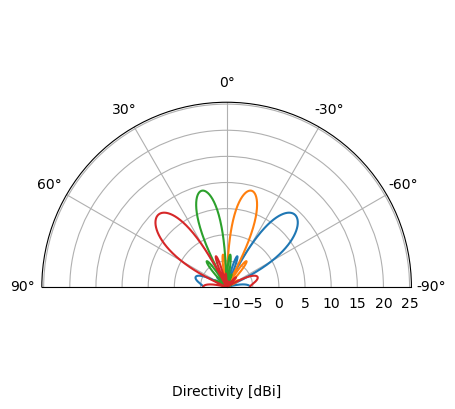

array([-45.67605512, -15.22535171,  15.22535171,  45.67605512])

In [34]:
receiving_codebook = Codebook(L_max = L_r , N1 = N_r, az_min = -60, az_max = 60)
receiving_codebook_vectors, beam_degs = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)
beam_degs

In [14]:
receiving_codebook_vectors

[array([ 0.35355339+0.j        , -0.19642374-0.2939689j ,
        -0.13529903+0.32664074j,  0.34675996-0.06897484j,
        -0.25      -0.25j      , -0.06897484+0.34675996j,
         0.32664074-0.13529903j, -0.2939689 -0.19642374j]),
 array([ 3.53553391e-01+0.00000000e+00j,  2.50000000e-01-2.50000000e-01j,
         2.16489014e-17-3.53553391e-01j, -2.50000000e-01-2.50000000e-01j,
        -3.53553391e-01-4.32978028e-17j, -2.50000000e-01+2.50000000e-01j,
        -6.49467042e-17+3.53553391e-01j,  2.50000000e-01+2.50000000e-01j]),
 array([ 3.53553391e-01+0.00000000e+00j,  2.50000000e-01+2.50000000e-01j,
         2.16489014e-17+3.53553391e-01j, -2.50000000e-01+2.50000000e-01j,
        -3.53553391e-01+4.32978028e-17j, -2.50000000e-01-2.50000000e-01j,
        -6.49467042e-17-3.53553391e-01j,  2.50000000e-01-2.50000000e-01j]),
 array([ 0.35355339+0.j        , -0.19642374+0.2939689j ,
        -0.13529903-0.32664074j,  0.34675996+0.06897484j,
        -0.25      +0.25j      , -0.06897484-0.3467599

In [37]:
# Removing the redundant dimesions from a --> (batch size (rays), receiving antennas, transmitting antennas)
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1]) 

<tf.Tensor: shape=(8, 8, 1), dtype=complex64, numpy=
array([[[ 3.1864570e-06+2.1714809e-06j],
        [-7.7864911e-07+3.7765781e-06j],
        [-3.7855070e-06+7.3401145e-07j],
        [-2.1337116e-06-3.2118701e-06j],
        [ 2.1439455e-06-3.2050482e-06j],
        [ 3.7831469e-06+7.4608090e-07j],
        [ 7.6659910e-07+3.7790426e-06j],
        [-3.1933669e-06+2.1613059e-06j]],

       [[ 2.4275487e-06-2.8687834e-06j],
        [ 3.4257562e-06+1.5450272e-06j],
        [-5.4336522e-07+3.7185571e-06j],
        [-3.7246091e-06+5.0019787e-07j],
        [-1.5051893e-06-3.4434456e-06j],
        [ 2.8967474e-06-2.3941109e-06j],
        [ 3.0984149e-06+2.1266726e-06j],
        [-1.1926027e-06+3.5637916e-06j]],

       [[ 3.0766833e-07+1.6031779e-06j],
        [-1.0183528e-06+1.2758516e-06j],
        [-1.6314935e-06+5.5386906e-08j],
        [-1.1025351e-06-1.2038504e-06j],
        [ 1.9823446e-07-1.6203527e-06j],
        [ 1.3602332e-06-9.0255469e-07j],
        [ 1.5700239e-06+4.4706181e-07j],


In [36]:
# Generating a matrix out of receiving_codebook_vectors --> # (batch size, N_r, L_r)
receiving_codebook_matrix = np.stack(receiving_codebook_vectors, axis = -1)  # (N_r, L_r)
# Add the dummy batch dimension
receiving_codebook_matrix = np.expand_dims(receiving_codebook_matrix, axis=0).astype(np.complex64)  

In [45]:
# Beam forming at the receiver by applying the weights 
# (batch size, N_r, L_r) * (batch size (rays), N_r, N_t) = (batch size, L_r, N_t))

beam_formed_receiving_signal = tf.matmul(receiving_codebook_matrix, a_reshaped, adjoint_a=True) 
beam_formed_receiving_signal # (batch size, L_r, N_t)

<tf.Tensor: shape=(8, 4, 1), dtype=complex64, numpy=
array([[[ 9.19282456e-07-2.7726094e-07j],
        [ 6.25471387e-07+1.5168606e-06j],
        [-2.69903012e-06+6.4867563e-06j],
        [ 1.96880137e-06+6.0066031e-07j]],

       [[ 2.75361828e-07-1.2425776e-06j],
        [ 1.37398433e-06+1.6554350e-07j],
        [ 2.93738890e-06+3.7421696e-06j],
        [ 7.37619985e-07-7.0623821e-07j]],

       [[-2.17174716e-07+1.4998608e-07j],
        [ 1.55633472e-07+1.8381009e-07j],
        [-3.75904449e-07+4.5285587e-06j],
        [ 8.50305412e-07-1.3059207e-08j]],

       [[-6.53527991e-07+6.5213811e-07j],
        [-1.27369105e-06-1.0475625e-06j],
        [-6.99846964e-07-7.1840473e-06j],
        [-2.08279198e-06+4.1198859e-07j]],

       [[-9.37068421e-07+9.4189704e-07j],
        [-8.72170745e-07-7.1202953e-07j],
        [-3.52659299e-07-3.4886873e-06j],
        [-2.31381478e-07+4.6642754e-08j]],

       [[-1.27355349e-06-3.5494259e-07j],
        [ 2.08114329e-07-1.1865325e-06j],
        [ 3.1

In [58]:
def beamforming_gain(a_reshaped, beam_formed_receiving_signal):

    receiving_signal_mag = np.abs(a_reshaped)
    beam_formed_receiving_signal_mag = np.abs(beam_formed_receiving_signal)
    gain = beam_formed_receiving_signal_mag / receiving_signal_mag[:, :1, :1]
    return gain
     
        
gain = beamforming_gain(a_reshaped = a_reshaped, beam_formed_receiving_signal = beam_formed_receiving_signal)
gain

array([[[0.24900958],
        [0.42550582],
        [1.8220539 ],
        [0.5338131 ]],

       [[0.33866608],
        [0.3682555 ],
        [1.2659023 ],
        [0.27173775]],

       [[0.16168076],
        [0.14753945],
        [2.7836561 ],
        [0.5209435 ]],

       [[0.23873664],
        [0.42644233],
        [1.8664739 ],
        [0.5490121 ]],

       [[0.35896745],
        [0.30419537],
        [0.9473698 ],
        [0.06377168]],

       [[0.35561535],
        [0.3240251 ],
        [1.0359339 ],
        [0.12591827]],

       [[0.26796767],
        [0.42184228],
        [1.7338574 ],
        [0.5009963 ]],

       [[0.26765972],
        [0.42192402],
        [1.735363  ],
        [0.5015853 ]]], dtype=float32)

In [31]:
for i in range(a_reshaped.shape[0]):  # Iterate over the first dimension which is batch size (rays)
    
    single_batch = a_reshaped[i, :, :]
    
    print(f"single batch {i + 1}:\n{single_batch.numpy()}\n")
    print(f"Azimuth angle of departure: {np.rad2deg(paths.phi_t[0,0,0,i]):.4f}\n")
    print(f"Azimuth angle of arrival: {np.rad2deg(paths.phi_r[0,0,0,i]):.4f}\n")
    
    for beam in receiving_codebook_vectors:
    
        beam = beam.astype(np.complex64)
        beam_reshaped = np.reshape(beam, (N_r, 1))
        transposed_conjugate_beam = beam_reshaped.T.conj()
        beam_formed_single_batch = transposed_conjugate_beam @ single_batch
        print(beam_formed_single_batch)
        #beam_formed_single_batch_mag = tf.abs(beam_formed_single_batch)   
        #print(beam_formed_single_batch_mag * math.sqrt(N_r))


single batch 1:
[[ 3.1864570e-06+2.1714809e-06j]
 [-7.7864911e-07+3.7765781e-06j]
 [-3.7855070e-06+7.3401145e-07j]
 [-2.1337116e-06-3.2118701e-06j]
 [ 2.1439455e-06-3.2050482e-06j]
 [ 3.7831469e-06+7.4608090e-07j]
 [ 7.6659910e-07+3.7790426e-06j]
 [-3.1933669e-06+2.1613059e-06j]]

Azimuth angle of departure: 12.6487

Azimuth angle of arrival: 21.9934

tf.Tensor([[9.1928246e-07-2.7726094e-07j]], shape=(1, 1), dtype=complex64)
tf.Tensor([[6.254714e-07+1.5168606e-06j]], shape=(1, 1), dtype=complex64)
tf.Tensor([[-2.6990301e-06+6.4867563e-06j]], shape=(1, 1), dtype=complex64)
tf.Tensor([[1.9688014e-06+6.006603e-07j]], shape=(1, 1), dtype=complex64)
single batch 2:
[[ 2.4275487e-06-2.8687834e-06j]
 [ 3.4257562e-06+1.5450272e-06j]
 [-5.4336522e-07+3.7185571e-06j]
 [-3.7246091e-06+5.0019787e-07j]
 [-1.5051893e-06-3.4434456e-06j]
 [ 2.8967474e-06-2.3941109e-06j]
 [ 3.0984149e-06+2.1266726e-06j]
 [-1.1926027e-06+3.5637916e-06j]]

Azimuth angle of departure: 15.2179

Azimuth angle of arrival: 24

In [32]:
# magnitude of a single antenna (r0) in one of the batches
single_batch
magnitude_result = tf.abs(single_batch)
magnitude_result

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[3.8416720e-06],
       [3.8416720e-06],
       [3.8416715e-06],
       [3.8416715e-06],
       [3.8416720e-06],
       [3.8416715e-06],
       [3.8416715e-06],
       [3.8416715e-06]], dtype=float32)>

In [33]:
for beam in receiving_codebook_vectors:

    beam = beam.astype(np.complex64)
    beam_reshaped = np.reshape(beam, (N_r, 1))
    transposed_conjugate_beam = beam_reshaped.T.conj()
    beam_formed_single_batch = transposed_conjugate_beam @ single_batch
    beam_formed_single_batch_mag = tf.abs(beam_formed_single_batch)   
    print(beam_formed_single_batch_mag * math.sqrt(N_r))


tf.Tensor([[2.9083608e-06]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.5845795e-06]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.885626e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.45017e-06]], shape=(1, 1), dtype=float32)


In [17]:
5.809842e-05/ magnitude_result[0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=15.1629>

In [17]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([2.1443235e-08, 2.0300513e-08, 2.4076659e-08, 2.0473946e-08,
       2.0832045e-08, 2.1234470e-08, 2.1707198e-08, 2.0428510e-08,
       2.0272504e-08, 2.0447864e-08, 2.0765432e-08, 2.1104674e-08,
       2.2691960e-08, 2.3156915e-08, 2.0949241e-08, 2.2629859e-08,
       2.2748655e-08, 2.1428853e-08, 2.2006835e-08], dtype=float32)>

In [18]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(receiving_signal, (tau.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_t + 1) for j in range(1, L_r + 1)]
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

,"1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","1,9","1,10","1,11","1,12","1,13","1,14","1,15","1,16"
2.144323e-08,-6.684331e-07-4.802646e-07j,-7.117080e-09-4.710884e-07j,-1.746852e-07+1.336925e-07j,-8.835550e-07-2.535136e-07j,-1.010045e-06-5.204187e-07j,-0.000000-0.000002j,0.000000-0.000003j,0.000002-0.000007j,-0.000004+0.000009j,-0.000002+0.000002j,-0.000001+0.000001j,-7.219805e-07-1.323058e-07j,-5.450216e-07-2.161688e-07j,5.776246e-08+2.166607e-07j,-4.784522e-07+6.012925e-07j,-8.297872e-07-2.820795e-08j
2.030051e-08,-8.815707e-07+1.175047e-08j,-3.012355e-07-3.950535e-07j,-6.869382e-08+2.378189e-07j,-9.310442e-07+3.471987e-07j,-1.212117e-06+1.963452e-07j,-0.000001-0.000001j,-0.000002-0.000002j,-0.000003-0.000007j,0.000002+0.000010j,0.000000+0.000003j,-0.000000+0.000002j,-6.960941e-07+3.406540e-07j,-5.982550e-07+1.583581e-07j,1.973541e-07+1.576096e-07j,-2.972661e-08+8.309412e-07j,-7.331277e-07+5.041222e-07j
2.407666e-08,-7.039068e-07+8.366007e-08j,-2.871275e-07-3.042626e-07j,-2.987144e-08+1.677457e-07j,-6.957101e-07+3.463433e-07j,-9.275261e-07+2.522705e-07j,-0.000001-0.000001j,-0.000001-0.000002j,-0.000003-0.000005j,0.000002+0.000008j,0.000000+0.000002j,-0.000000+0.000001j,-5.507484e-07+3.453546e-07j,-4.856181e-07+1.848607e-07j,1.460471e-07+9.339061e-08j,4.484031e-08+6.468659e-07j,-5.430408e-07+4.642575e-07j
2.047395e-08,-8.603011e-07+1.445468e-07j,-3.550850e-07-3.417032e-07j,-3.104316e-08+2.410824e-07j,-8.568164e-07+4.793535e-07j,-1.154069e-06+3.744274e-07j,-0.000001-0.000001j,-0.000002-0.000002j,-0.000004-0.000006j,0.000004+0.000009j,0.000001+0.000003j,-0.000000+0.000002j,-6.307291e-07+4.391882e-07j,-5.624395e-07+2.457263e-07j,2.150994e-07+1.233745e-07j,9.619259e-08+8.157527e-07j,-6.407839e-07+6.035847e-07j
2.083205e-08,7.484997e-07-4.104306e-07j,4.403095e-07+2.025185e-07j,-4.813938e-08-2.291785e-07j,6.356805e-07-7.166163e-07j,9.433335e-07-7.153838e-07j,0.000002+0.000000j,0.000002+0.000001j,0.000006+0.000005j,-0.000006-0.000008j,-0.000001-0.000003j,-0.000001-0.000002j,4.435726e-07-6.116497e-07j,4.427645e-07-4.100060e-07j,-2.347217e-07-4.408548e-08j,-3.502796e-07-7.205679e-07j,3.978645e-07-7.638874e-07j
2.123447e-08,2.718376e-07-7.877425e-07j,4.536248e-07-1.432345e-07j,-1.819797e-07-1.317977e-07j,-1.055466e-08-9.320983e-07j,2.119701e-07-1.132516e-06j,0.000001-0.000001j,0.000003-0.000001j,0.000007-0.000000j,-0.000009-0.000001j,-0.000003-0.000001j,-0.000002-0.000001j,-8.100601e-08-7.368352e-07j,5.136047e-08-5.898692e-07j,-1.951405e-07+1.199868e-07j,-7.233840e-07-2.900834e-07j,-2.134862e-07-8.131095e-07j
2.170720e-08,-2.329105e-07+4.991820e-07j,-3.014027e-07+6.159212e-08j,1.182518e-07+1.060568e-07j,-5.791762e-08+6.213241e-07j,-2.199473e-07+7.389509e-07j,-0.000001+0.000000j,-0.000002+0.000000j,-0.000005-0.000000j,0.000006+0.000002j,0.000002+0.000001j,0.000001+0.000001j,2.510149e-09+4.802288e-07j,-7.283532e-08+3.764412e-07j,1.462209e-07-7.009487e-08j,4.620296e-07+2.438636e-07j,8.445944e-08+5.495726e-07j
2.042851e-08,1.033572e-07-5.921032e-07j,3.012097e-07-1.512342e-07j,-1.528850e-07-7.714991e-08j,-1.154602e-07-6.694376e-07j,2.144930e-08-8.391089e-07j,0.000001-0.000001j,0.000002-0.000001j,0.000005-0.000001j,-0.000007+0.000000j,-0.000002-0.000000j,-0.000001-0.000000j,-1.397718e-07-5.070668e-07j,-3.047113e-08-4.188712e-07j,-1.324559e-07+1.140237e-07j,-5.546573e-07-1.251427e-07j,-2.452750e-07-5.548476e-07j
2.027250e-08,7.600668e-07+4.497513e-07j,5.155408e-08+4.947718e-07j,1.830139e-07-1.677665e-07j,9.775659e-07+1.887167e-07j,1.139294e-06+4.643902e-07j,0.000000+0.000002j,0.000000+0.000003j,-0.000001+0.000007j,0.000003-0.000010j,0.000002-0.000003j,0.000001-0.000001j,7.727000e-07+7.170031e-08j,5.940076e-07+1.765330e-07j,-8.668610e-08-2.380248e-07j,4.589351e-07-6.953142e-07j,8.899312e-07-4.875929e-08j
2.044786e-08,5.661552e-07-1.993911e-07j,2.789073e-07+1.883802e-07j,-7.539967e-09-1.708817e-07j,5.265702e-07-4.277640e-07j,7.412536e-07-3.914636e-07j,0.000001+0.000001j,0.000002+0.000001j,0.000003+0.000004j,-0.000004-0.000006j,-0.000001-0.

In [19]:
channel_magnitude_df = abs_complex_columns(df1)
channel_magnitude_df

,"1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","1,9","1,10","1,11","1,12","1,13","1,14","1,15","1,16"
2.144323e-08,8.230777e-07,4.711421e-07,2.199741e-07,9.192054e-07,1.136233e-06,0.000002,0.000003,0.000007,0.000009,0.000003,0.000002,7.340032e-07,5.863254e-07,2.242283e-07,7.684199e-07,8.302665e-07
2.030051e-08,8.816490e-07,4.967999e-07,2.475412e-07,9.936751e-07,1.227917e-06,0.000002,0.000003,0.000008,0.000010,0.000003,0.000002,7.749788e-07,6.188589e-07,2.525657e-07,8.314728e-07,8.897277e-07
2.407666e-08,7.088609e-07,4.183515e-07,1.703847e-07,7.771527e-07,9.612206e-07,0.000001,0.000002,0.000006,0.000008,0.000002,0.000001,6.500720e-07,5.196137e-07,1.733539e-07,6.484182e-07,7.144427e-07
2.047395e-08,8.723599e-07,4.927946e-07,2.430728e-07,9.817913e-07,1.213289e-06,0.000002,0.000003,0.000007,0.000010,0.000003,0.000002,7.685736e-07,6.137749e-07,2.479698e-07,8.214046e-07,8.802946e-07
2.083205e-08,8.536422e-07,4.846507e-07,2.341798e-07,9.579293e-07,1.183914e-06,0.000002,0.000003,0.000007,0.000010,0.000003,0.000002,7.555607e-07,6.034445e-07,2.388258e-07,8.011953e-07,8.612898e-07
2.123447e-08,8.333270e-07,4.757011e-07,2.246936e-07,9.321580e-07,1.152183e-06,0.000002,0.000003,0.000007,0.000010,0.000003,0.000002,7.412746e-07,5.921009e-07,2.290778e-07,7.793798e-07,8.406684e-07
2.170720e-08,5.508448e-07,3.076316e-07,1.588444e-07,6.240177e-07,7.709897e-07,0.000001,0.000002,0.000005,0.000006,0.000002,0.000001,4.802353e-07,3.834227e-07,1.621537e-07,5.224373e-07,5.560247e-07
2.042851e-08,6.010565e-07,3.370446e-07,1.712481e-07,6.793215e-07,8.393830e-07,0.000001,0.000002,0.000005,0.000007,0.000002,0.000001,5.259781e-07,4.199780e-07,1.747740e-07,5.685996e-07,6.066430e-07
2.027250e-08,8.831635e-07,4.974504e-07,2.482734e-07,9.956150e-07,1.230304e-06,0.000002,0.000003,0.000008,0.000010,0.000003,0.000002,7.760195e-07,6.196846e-07,2.533186e-07,8.331166e-07,8.912659e-07
2.044786e-08,6.002403e-07,3.365656e-07,1.710480e-07,6.784233e-07,8.382725e-07,0.000001,0.000002,0.000005,0.000007,0.000002,0.000001,5.252331e-07,4.193830e-07,1.745702e-07,5.678500e-07,6.058204e-07


In [20]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df.max()
m

1,1     8.831635e-07
1,2     4.974504e-07
1,3     2.482734e-07
1,4     9.956150e-07
1,5     1.230304e-06
1,6     1.751687e-06
1,7     2.786424e-06
1,8     7.513383e-06
1,9     1.022432e-05
1,10    3.077403e-06
1,11    1.853208e-06
1,12    7.760195e-07
1,13    6.196846e-07
1,14    2.533186e-07
1,15    8.331166e-07
1,16    8.912659e-07
dtype: float64

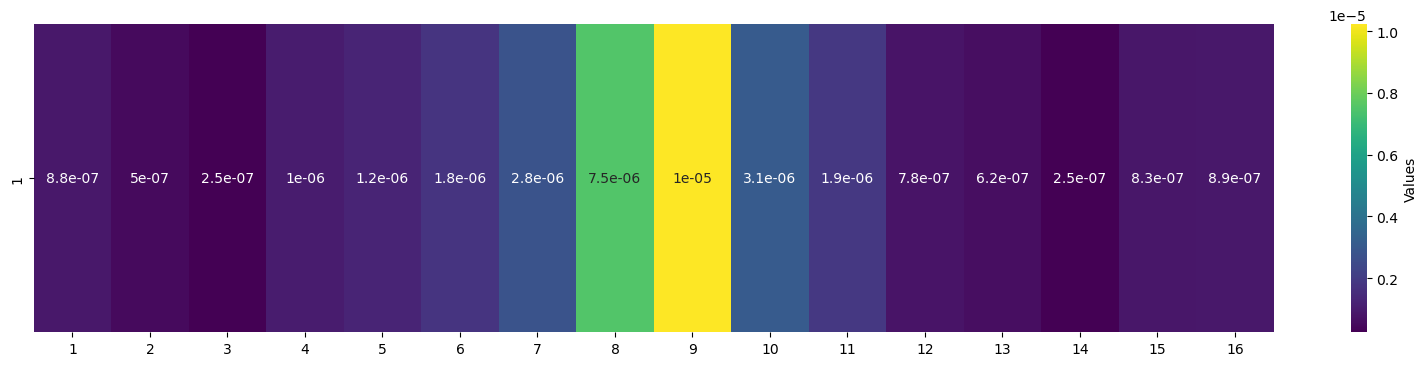

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

plt.figure(figsize=(20, 4))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))

# Display the heatmap
plt.show()

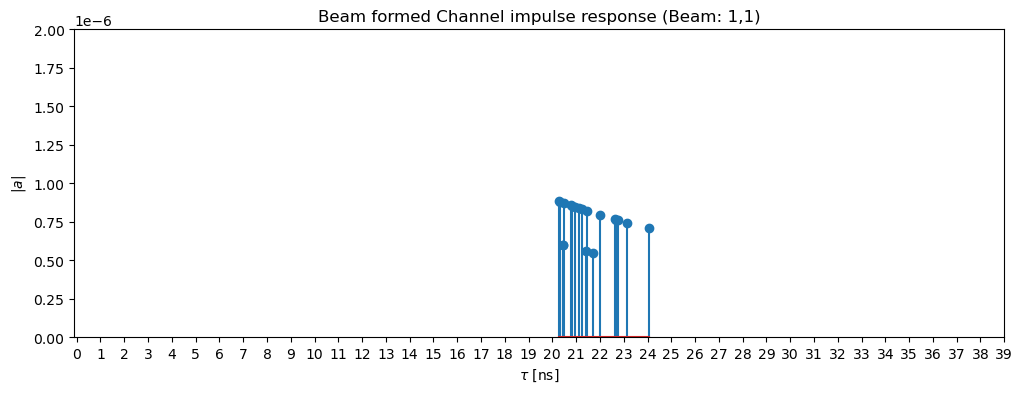

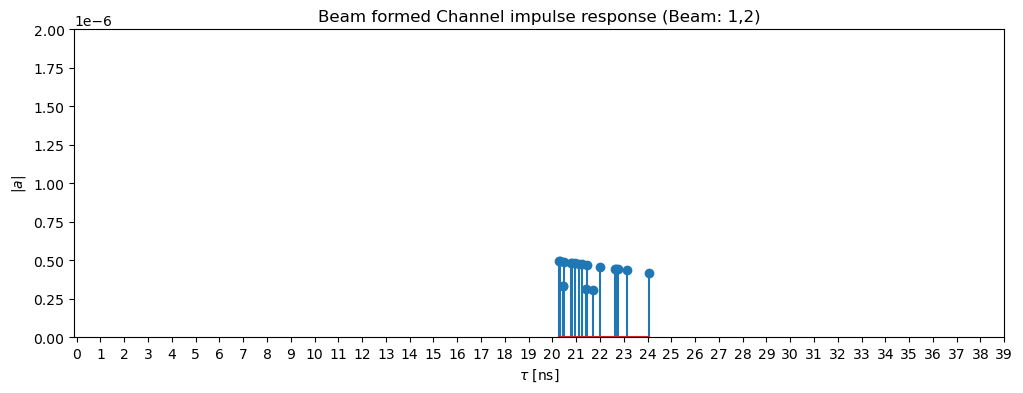

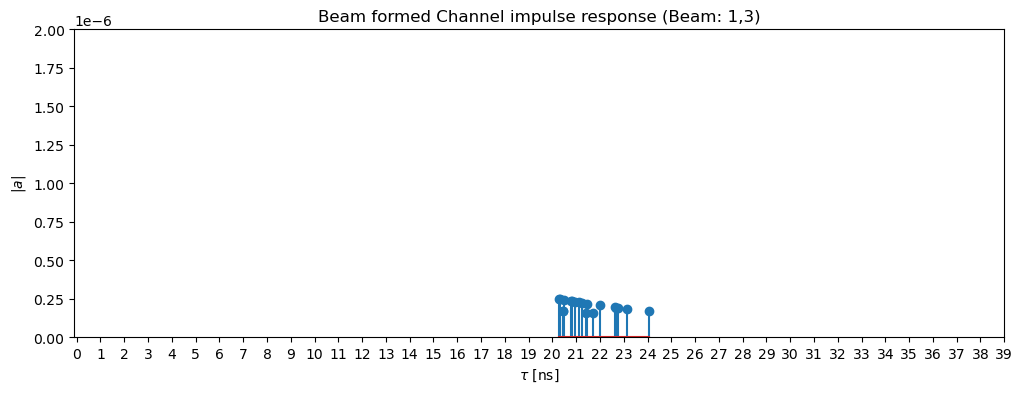

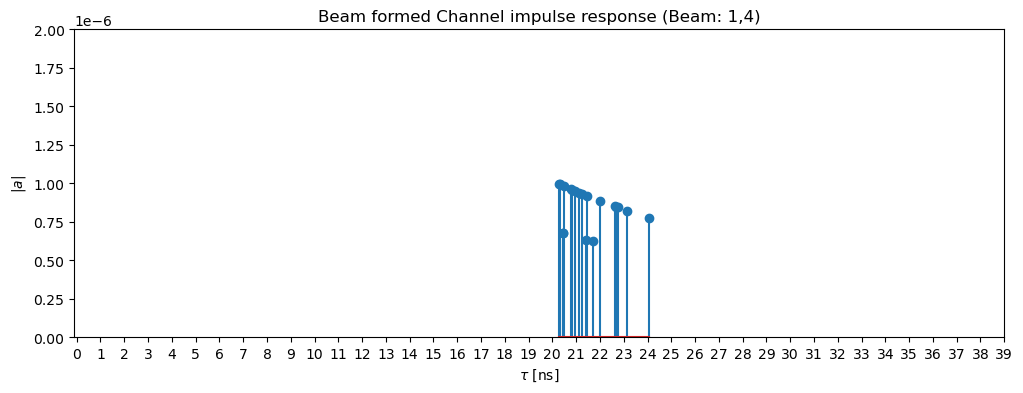

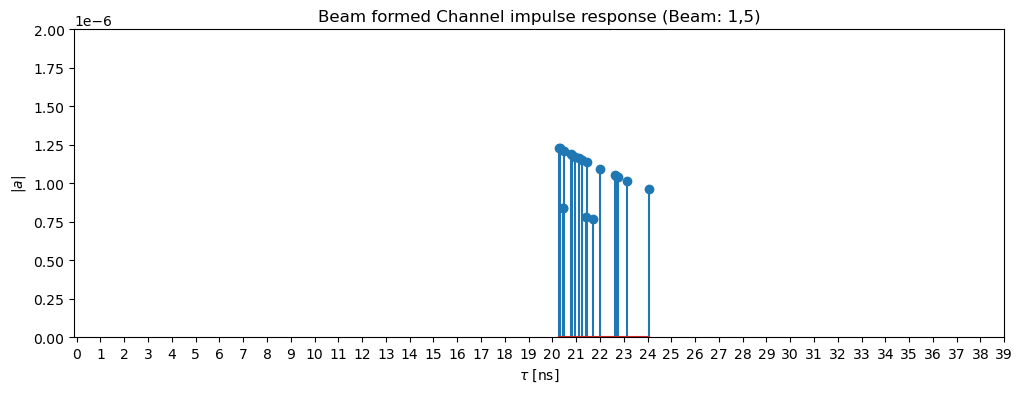

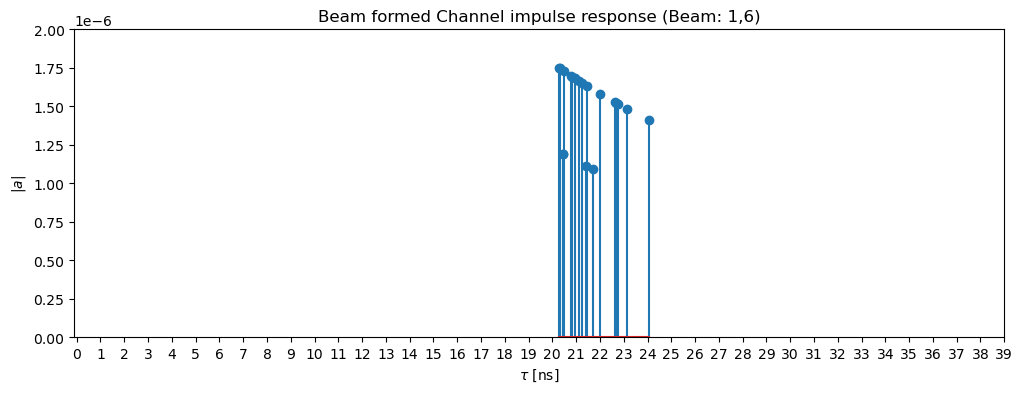

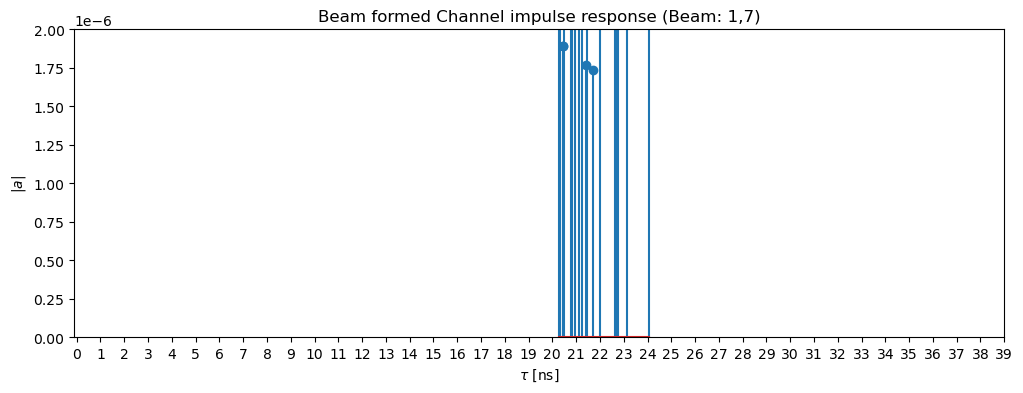

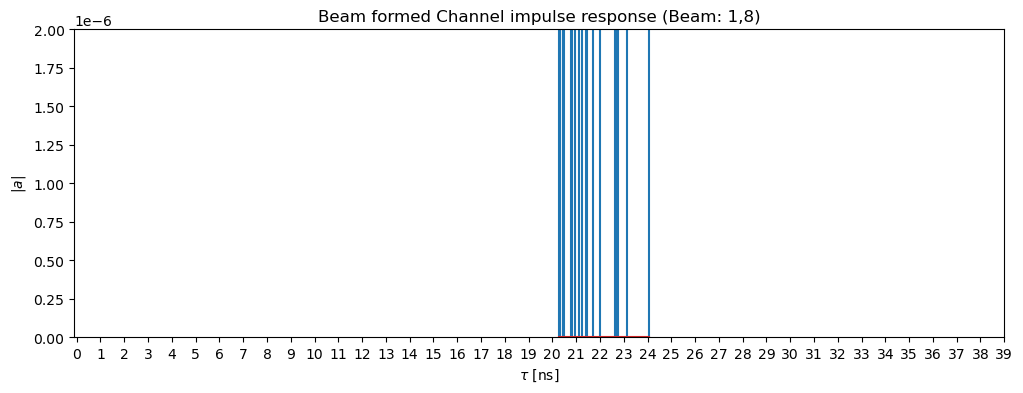

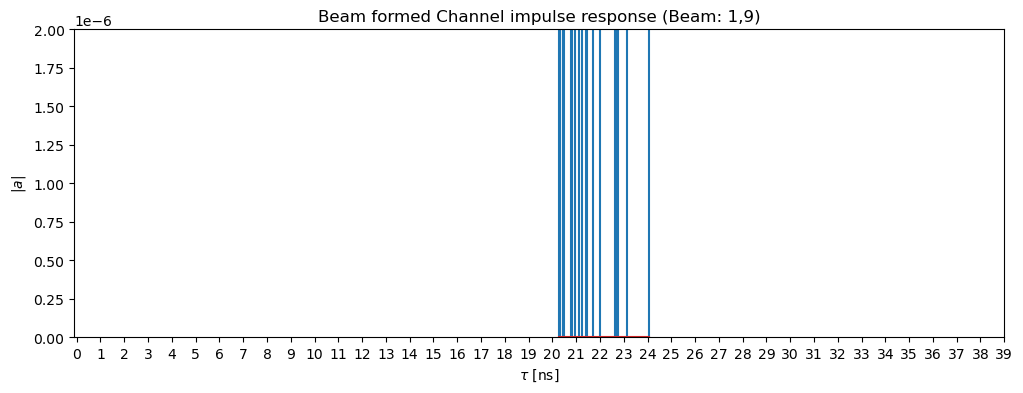

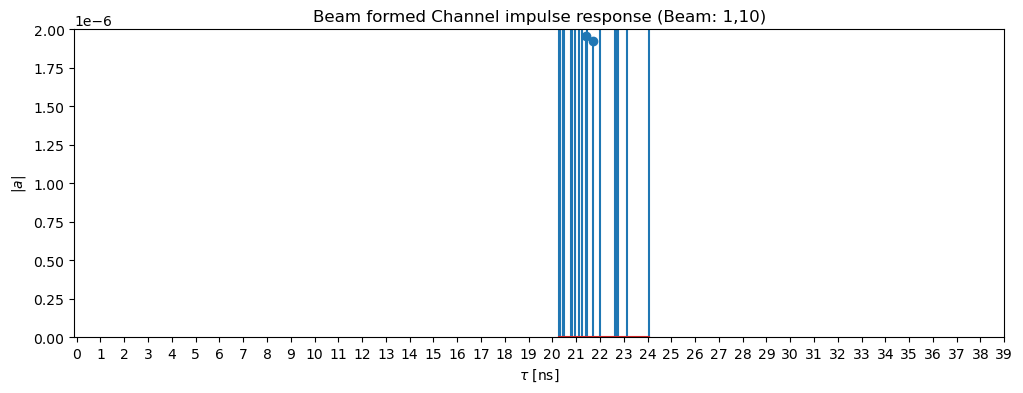

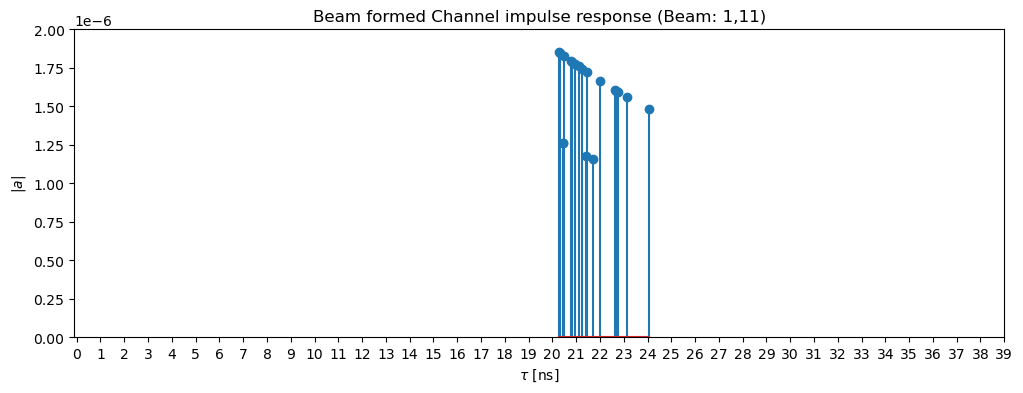

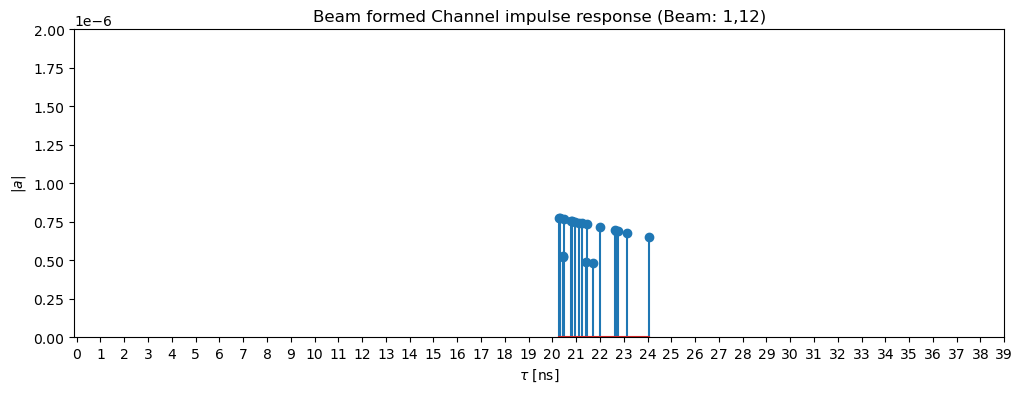

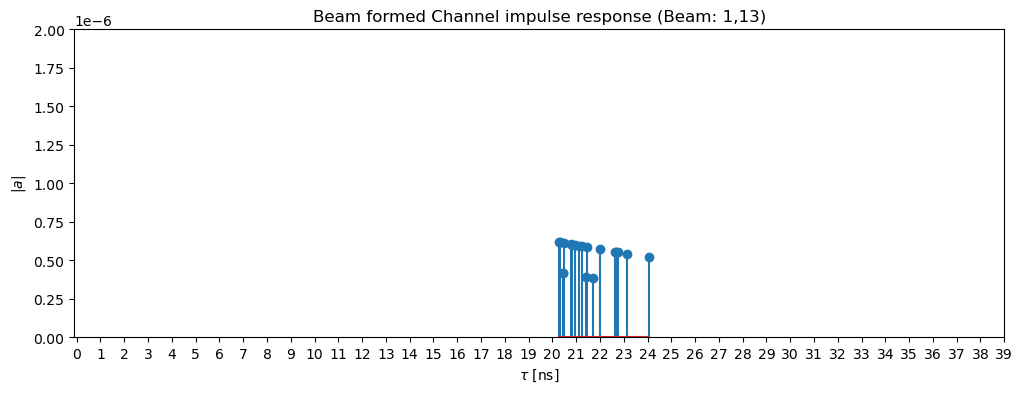

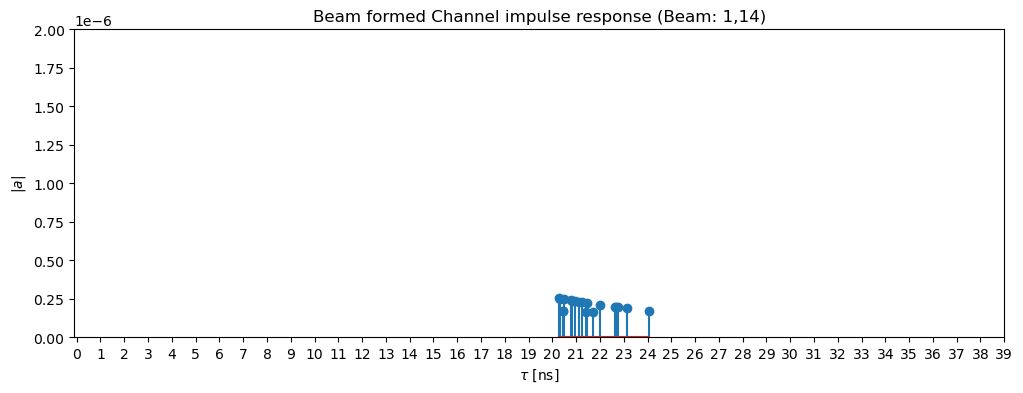

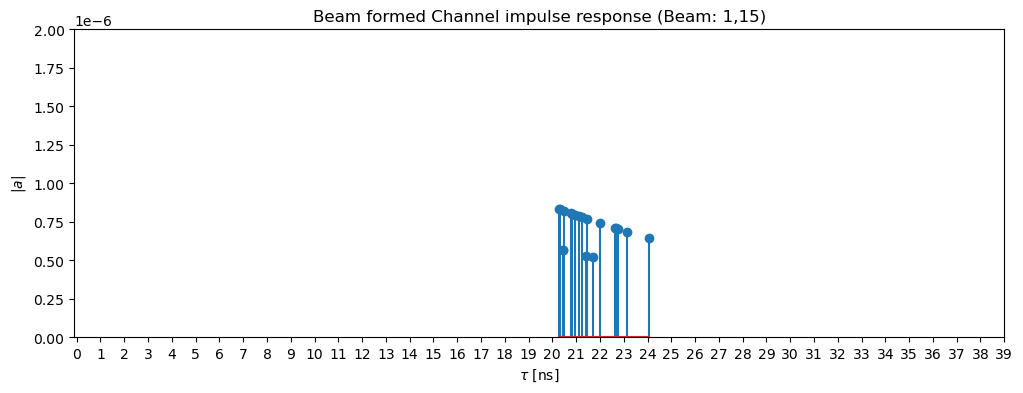

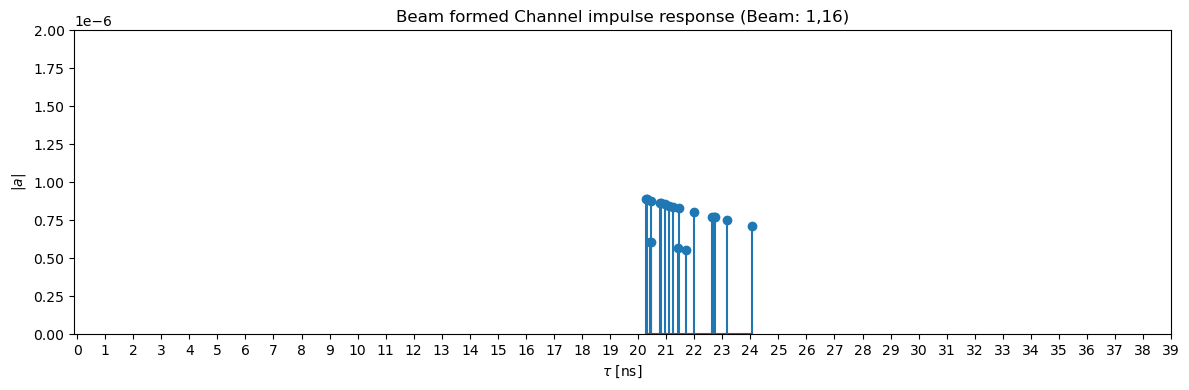

In [22]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 2e-6])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()